In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

from likelihood.models.deep import (
    AutoClassifier,
    setup_model,
    GetInsights,
)  # Modelos de deep learning personalizados
from likelihood.tools import OneHotEncoder, get_metrics  # Herramientas auxiliares

warnings.filterwarnings("ignore")
import tensorflow as tf

import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10
plt.style.use("seaborn-v0_8")

In [2]:
# Cargar el dataset de cáncer de mama desde sklearn
df = datasets.load_breast_cancer()

# Convertir los datos a un DataFrame de pandas para facilitar la manipulación
df_cancer = pd.DataFrame(data=df.data, columns=df.feature_names)
df_cancer["target"] = df.target  # Añadir la columna de etiquetas 'target'

# OneHotEncoder convierte las etiquetas a formato one-hot encoding
y_encoder = OneHotEncoder()
y = y_encoder.encode(df_cancer["target"].to_list())  # Codificar las etiquetas de la clase (target)
X = df_cancer.drop(
    columns="target"
).to_numpy()  # Extraer las características (sin la columna 'target')
X = np.asarray(X).astype(np.float32)  # Convertir X a tipo float32 para la entrada del modelo
y = np.asarray(y).astype(np.float32)  # Convertir y a tipo float32

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Crear el modelo de clasificación automática con las especificaciones dadas
model = AutoClassifier(
    input_shape_parm=X.shape[1],  # El número de características de entrada (columnas de X)
    num_classes=y.shape[1],  # El número de clases (salidas) del modelo
    units=17,  # Número de unidades en las capas ocultas
    activation="relu",  # Función de activación de las capas ocultas
    l2_reg=0.0,
    vae_mode=True,
)

# Compilación del modelo: optimizador, función de pérdida y métricas
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)

# Pre-entrenamiento del encoder-decoder para el uso de un VAE
model.train_encoder_decoder(X_train, epochs=100, batch_size=32, verbose=True)

# Entrenar el modelo con los datos, usando 15 épocas y 20% de los datos para validación
model.fit(X_train, y_train, epochs=15, validation_split=0.2, verbose=False)

# Hacer predicciones sobre el conjunto de entrenamiento
pred = model.predict(X)

# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df = df_cancer.copy()
y_labels = df.drop(columns="target").columns.to_list()
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1

# Calcular y mostrar las métricas del modelo comparando las etiquetas reales y las predicciones
get_metrics(df_cancer, "target", "prediction", verbose=True)

# Guardar el DataFrame con las predicciones en un archivo CSV
df_cancer.to_csv("test.csv", index=False)

# Guardar el modelo entrenado en el disco en formato TensorFlow
model.save("best_model", save_format="tf")

Epoch 0: Loss: 35425.914062
Epoch 10: Loss: 35374.722656
Epoch 20: Loss: 35346.953125
Epoch 30: Loss: 35314.859375
Epoch 40: Loss: 35286.621094
Epoch 50: Loss: 35258.613281
Epoch 60: Loss: 35232.882812
Epoch 70: Loss: 35218.914062
Epoch 80: Loss: 35178.203125
Epoch 90: Loss: 35153.796875
18/18 [==============================] - 0s 2ms/step
Accuracy: 87.87%
Precision: 84.45%
Recall: 98.88%
F1-Score: 91.10
Cohen's Kappa: 0.7245


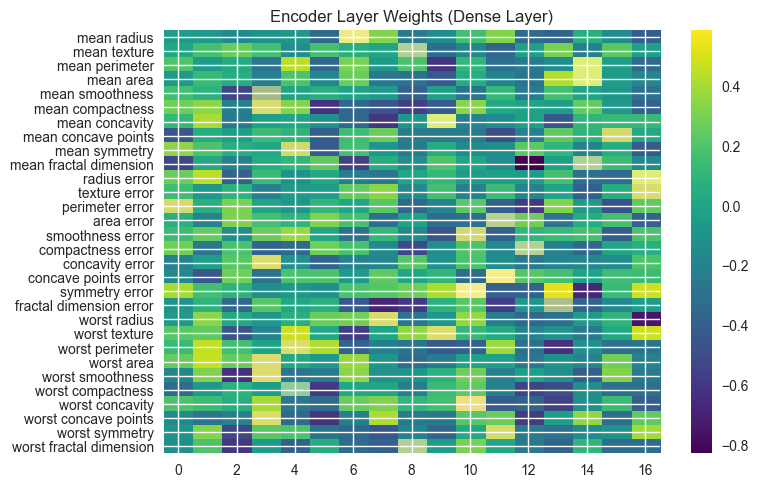

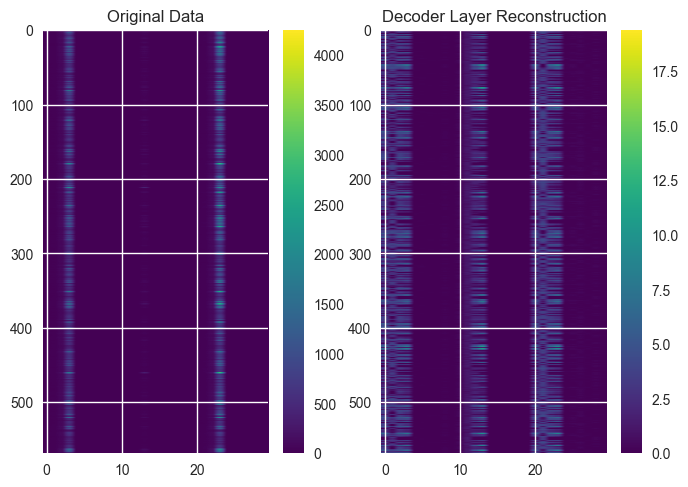

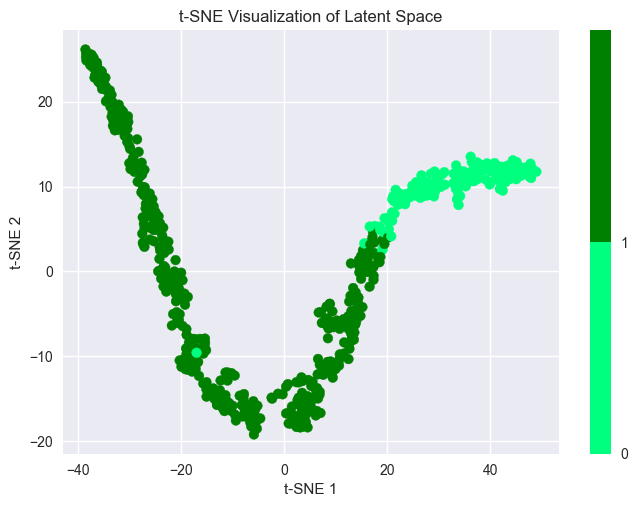

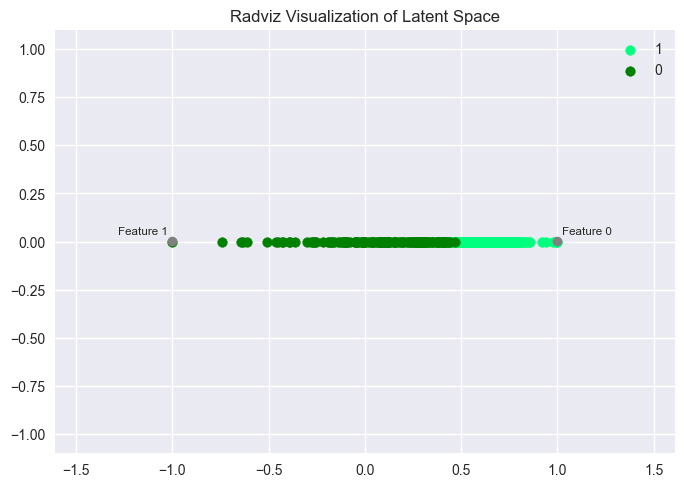

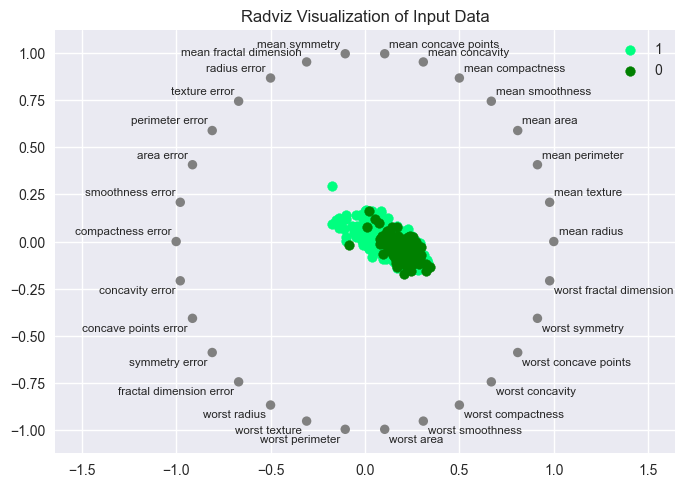

In [4]:
insights = GetInsights(model, X)
summary = insights.predictor_analyzer(frac=1.0, y_labels=y_labels)

In [5]:
model = tf.keras.models.load_model("best_model")
print("Modelo cargado desde disco.")
# Fine-tuning del modelo con más épocas de entrenamiento
model.freeze_encoder_decoder()  # Congelar las capas de encoder y decoder
model.compile(
    optimizer="adam",  # Optimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(),  # Función de pérdida para clasificación multiclase
    metrics=[
        tf.keras.metrics.F1Score(threshold=0.5)
    ],  # Métrica F1 (threshold = 0.5 para predicciones)
)
model.fit(X_train, y_train, epochs=15, validation_split=0.2, verbose=False)
model.summary()

model.save("fine_tuned_model", save_format="tf")
print("Modelo fine-tuned guardado en disco.")
model = tf.keras.models.load_model("fine_tuned_model")
print("Modelo fine-tuned cargado desde disco.")

# Hacer predicciones nuevamente con el modelo fine-tuned
pred = model.predict(X)

# Obtener las etiquetas predichas para las nuevas predicciones
pred_label = np.argmax(pred, axis=1)

# Añadir las nuevas predicciones al DataFrame original
df["prediction"] = pred_label

# Calcular y mostrar las métricas nuevamente con el modelo fine-tuned
get_metrics(df, "target", "prediction", verbose=True)

Modelo cargado desde disco.
Model: "auto_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               807       
                              (None, 2)]                         
                                                                 
 sequential (Sequential)     (None, 30)                779       
                                                                 
 sequential (Sequential)     (None, 2)                 66        
                                                                 
Total params: 1652 (6.45 KB)
Trainable params: 66 (264.00 Byte)
Non-trainable params: 1586 (6.20 KB)
_________________________________________________________________
Modelo fine-tuned guardado en disco.
Modelo fine-tuned cargado desde disco.
18/18 [==============================] - 0s 1ms/step
Accuracy: 88.22%
Precision: 85.37%
Recall: 98.04%
F1-Scor

In [6]:
model = tf.keras.models.load_model("best_model")

pred = model.predict(X)
# Convertir las predicciones a las etiquetas predichas (máxima probabilidad)
pred_label = np.argmax(pred, axis=1)

# Añadir las predicciones al DataFrame original para su análisis
df_cancer["prediction"] = pred_label  # Columna de las etiquetas predichas
df_cancer["label_0"] = pred[:, 0]  # Probabilidad de la clase 0
df_cancer["label_1"] = pred[:, 1]  # Probabilidad de la clase 1
get_metrics(df_cancer, "target", "prediction", verbose=True)

18/18 [==============================] - 0s 2ms/step
Accuracy: 88.58%
Precision: 85.27%
Recall: 98.88%
F1-Score: 91.57
Cohen's Kappa: 0.7415


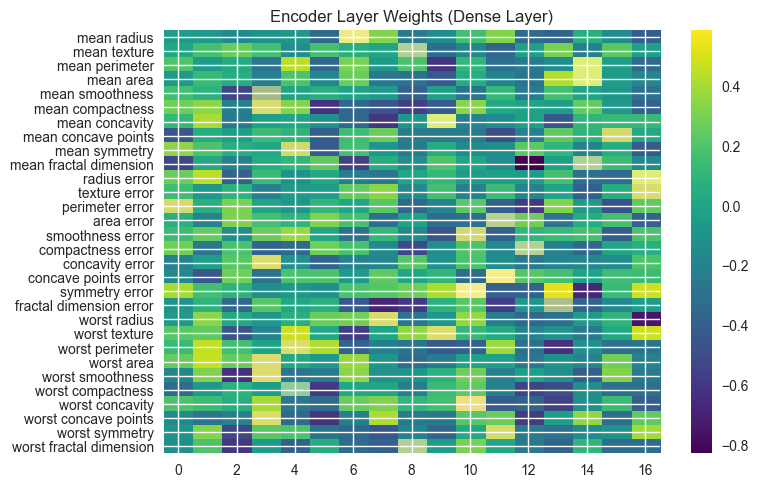

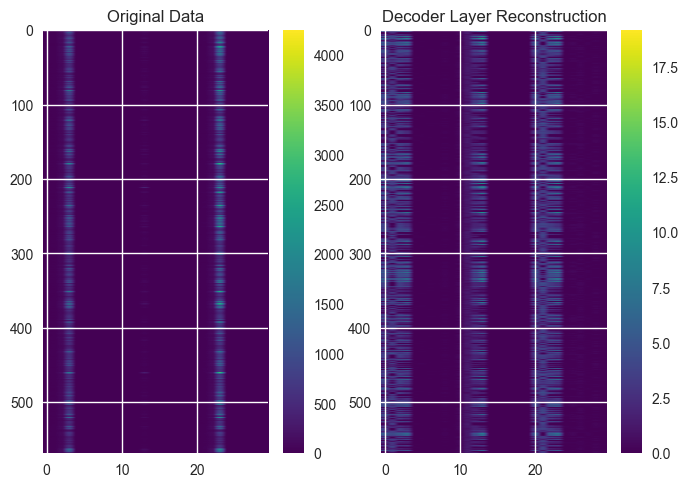

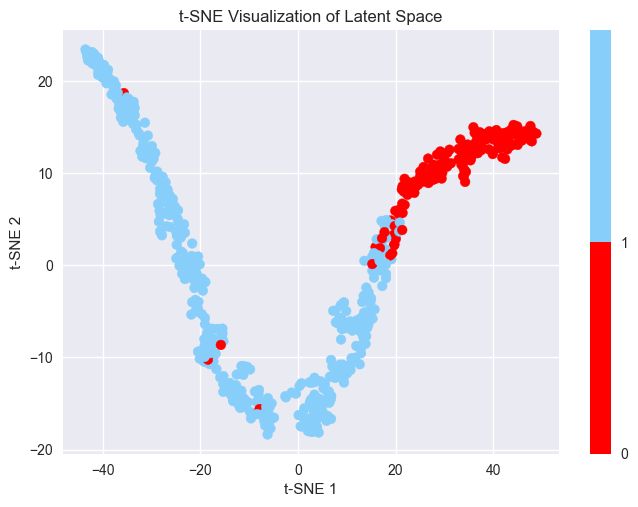

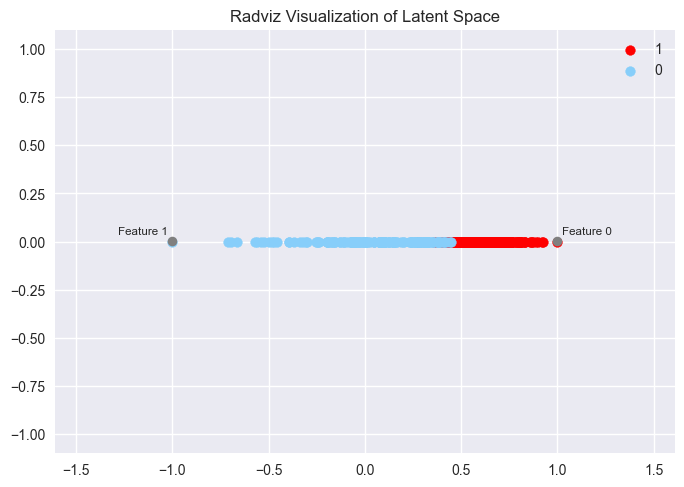

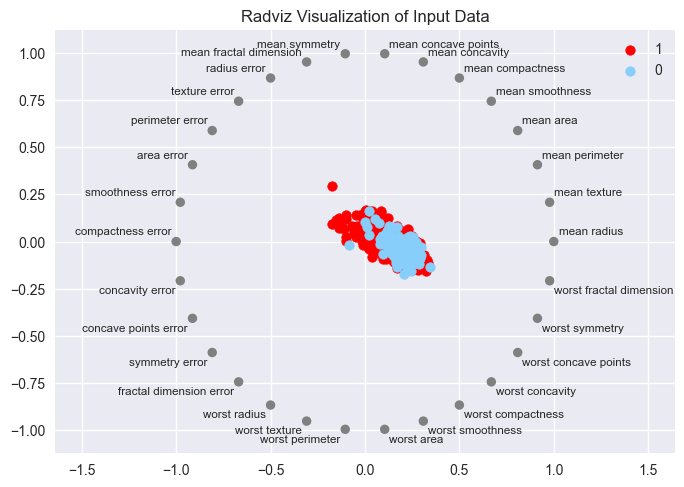

In [7]:
insights = GetInsights(model, X)
summary = insights.predictor_analyzer(frac=1.0, y_labels=y_labels)